### 予測モデルの仕組みをわかりやすく説明します！

#### どんなことを予測するの？
このモデルは、**「当月末における翌月のスタートMP」**と**「翌月末の限界利益」**を予測するものです。

#### 具体例で説明します

**例：4月15日時点のケース**

4月15日に、5月（翌月）のために既に積み上がっているデータがあります：
- 次月確定MP：500,000円
- 次月A：45,000,000円
- 次月B：4,500,000円
- 次月C：3,000,000円
- 次月D：15,000,000円

このデータから、このモデルは2つのことを教えてくれます：

1. **「4月末時点で確定する5月のスタートMP」** = 次月確定 + 次月A
   - つまり、500,000円 + 45,000,000円 = **45,500,000円**
   - これは5月1日の時点で既に確定しているMP（ほぼ確実に手に入る限界利益）です

2. **「5月末の最終的な限界利益の予測」**
   - スタートMPに加えて、B・C・Dがどれくらい追加で積み上がるかを予測
   - 例：45,500,000円 + 追加分 = **約68,000,000円（予測）**

#### なぜこのモデルが便利なの？

- **4月中に、5月の見通しが立てられる**
  - 4月15日時点で、既に「5月はこれくらいのMPでスタートできる」が分かる
  - さらに「5月末にはこれくらいまで伸びそうだ」も予測できる

- **日ごとに予測が更新される**
  - 4月1日、4月15日、4月30日と、日が進むにつれて予測の精度が上がる
  - 次月のデータが積み上がるほど、翌月の見通しがクリアになる

#### どうやって予測するの？

1. **翌月のスタートMP（確定部分）**
   - 次月確定MP + 次月A = スタートMP
   - これは計算するだけ（予測不要）

2. **翌月末までの追加分（予測部分）**
   - 次月B、C、Dが翌月中にどれくらい追加MPに変わるか
   - 過去のデータから学んだ「転換率」を使って予測
   - ランダムフォレストと月別転換率を組み合わせて精度向上

3. **合計**
   - スタートMP + 追加分 = 翌月末の予測MP

#### まとめ

**このモデルは、当月の日次データ（次月確定、次月A、次月B、次月C、次月D）を使って**：
- ✅ **当月末時点で確定する翌月のスタートMP**（次月確定 + 次月A）
- ✅ **翌月末の最終的な限界利益の予測**

**この2つを教えてくれる予測ツールです！**

# MP Next Month-End Prediction Model
## 日次の次月データから翌月末MP予測モデル

## 1. ライブラリのインポート

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print('Libraries loaded!')

Libraries loaded!


## 2. データの読み込み

In [2]:
try:
    from google.colab import files
    print('Upload CSV file:')
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
except:
    filename = 'progress_data.csv'
    print(f'Using: {filename}')

Upload CSV file:


Saving 進捗データ(新)_2026020317540815025.csv to 進捗データ(新)_2026020317540815025.csv


In [3]:
try:
    df = pd.read_csv(filename, encoding='utf-8-sig')
except:
    df = pd.read_csv(filename, encoding='shift_jis')

print(f'Shape: {df.shape}')
print(f'Columns: {df.columns.tolist()}')
df.head()

Shape: (2144, 13)
Columns: ['行ラベル', '合計 / MP', '合計 / 確定MP', '合計 / AMP', '合計 / BMP', '合計 / CMP', '合計 / DMP', '合計 / 次月MP', '合計 / 次月確定MP', '合計 / 次月AMP', '合計 / 次月BMP', '合計 / 次月CMP', '合計 / 次月DMP']


,行ラベル,合計 / MP,合計 / 確定MP,合計 / AMP,合計 / BMP,合計 / CMP,合計 / DMP,合計 / 次月MP,合計 / 次月確定MP,合計 / 次月AMP,合計 / 次月BMP,合計 / 次月CMP,合計 / 次月DMP
0,2020/04/01,52612321,3560426,49051895,9945801,6513693,24336375,15815626,0,15815626,1787889,2610055,58101088
1,2020/04/02,56827598,3851781,52975817,7023531,5452199,22024972,16514617,0,16514617,2656829,3009163,54178242
2,2020/04/03,58726803,5588962,53137841,5750444,5316388,19336368,16344677,0,16344677,3487701,3368643,50733450
3,2020/04/04,58726803,5588962,53137841,5750444,5316388,19336368,16344677,0,16344677,3487701,3368643,50733450
4,2020/04/05,59218260,5742347,53475913,5744476,5316685,19336368,16523619,0,16523619,3487701,4072319,50733450


## 3. データ前処理（日次の次月データを使用）

In [4]:
# 元のカラム名を保存
original_columns = df.columns.tolist()
print(f'Original columns: {original_columns}')

# 日付処理
df['date'] = pd.to_datetime(df.iloc[:, 0], errors='coerce')
# NaT（無効な日付）を含む行を削除
df = df.dropna(subset=['date']).copy()

# 年月情報を追加
df['year_month'] = df['date'].dt.to_period('M')
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

print(f'\nDaily data points: {len(df)}')

Original columns: ['行ラベル', '合計 / MP', '合計 / 確定MP', '合計 / AMP', '合計 / BMP', '合計 / CMP', '合計 / DMP', '合計 / 次月MP', '合計 / 次月確定MP', '合計 / 次月AMP', '合計 / 次月BMP', '合計 / 次月CMP', '合計 / 次月DMP']

Daily data points: 2144


In [5]:
# カラム名を変更（次月の確定、A、B、C、Dに対応）
# 13列フォーマットの場合は列8-12、12列フォーマットの場合は列7-11、7列フォーマットの場合は列2-6を使用
if len(original_columns) >= 13:
    # 13列フォーマット: 次月データを使用（列8-12）
    col_mapping = {
        original_columns[1]: 'Current_MP',     # 当月MP（参考用）
        original_columns[7]: 'Next_MP',        # 次月MP（参考用）
        original_columns[8]: 'Next_Kakutei',   # 次月確定MP
        original_columns[9]: 'Next_A',         # 次月AMP
        original_columns[10]: 'Next_B',        # 次月BMP
        original_columns[11]: 'Next_C',        # 次月CMP
        original_columns[12]: 'Next_D'         # 次月DMP
    }
    print('Using 13-column format (next month data from columns 8-12)')
elif len(original_columns) >= 12:
    # 12列フォーマット: 次月データを使用（列7-11）
    col_mapping = {
        original_columns[1]: 'Current_MP',     # 当月MP（参考用）
        original_columns[7]: 'Next_Kakutei',   # 次月確定MP
        original_columns[8]: 'Next_A',         # 次月AMP
        original_columns[9]: 'Next_B',         # 次月BMP
        original_columns[10]: 'Next_C',        # 次月CMP
        original_columns[11]: 'Next_D'         # 次月DMP
    }
    print('Using 12-column format (next month data from columns 7-11)')
else:
    # 7列フォーマット: 次月データのみ（列2-6）
    col_mapping = {
        original_columns[1]: 'Current_MP',
        original_columns[2]: 'Next_Kakutei',
        original_columns[3]: 'Next_A',
        original_columns[4]: 'Next_B',
        original_columns[5]: 'Next_C',
        original_columns[6]: 'Next_D'
    }
    print('Using 7-column format (next month data only)')

print(f'Mapping: {col_mapping}')

df = df.rename(columns=col_mapping)

# 数値変換
for col in ['Current_MP', 'Next_MP', 'Next_Kakutei', 'Next_A', 'Next_B', 'Next_C', 'Next_D']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print(f'\nColumns after mapping: {df.columns.tolist()}')
df.head()

Using 13-column format (next month data from columns 8-12)
Mapping: {'合計 / MP': 'Current_MP', '合計 / 次月MP': 'Next_MP', '合計 / 次月確定MP': 'Next_Kakutei', '合計 / 次月AMP': 'Next_A', '合計 / 次月BMP': 'Next_B', '合計 / 次月CMP': 'Next_C', '合計 / 次月DMP': 'Next_D'}

Columns after mapping: ['行ラベル', 'Current_MP', '合計 / 確定MP', '合計 / AMP', '合計 / BMP', '合計 / CMP', '合計 / DMP', 'Next_MP', 'Next_Kakutei', 'Next_A', 'Next_B', 'Next_C', 'Next_D', 'date', 'year_month', 'month', 'day']


,行ラベル,Current_MP,合計 / 確定MP,合計 / AMP,合計 / BMP,合計 / CMP,合計 / DMP,Next_MP,Next_Kakutei,Next_A,Next_B,Next_C,Next_D,date,year_month,month,day
0,2020/04/01,52612321,3560426,49051895,9945801,6513693,24336375,15815626,0,15815626,1787889,2610055,58101088,2020-04-01,2020-04,4,1
1,2020/04/02,56827598,3851781,52975817,7023531,5452199,22024972,16514617,0,16514617,2656829,3009163,54178242,2020-04-02,2020-04,4,2
2,2020/04/03,58726803,5588962,53137841,5750444,5316388,19336368,16344677,0,16344677,3487701,3368643,50733450,2020-04-03,2020-04,4,3
3,2020/04/04,58726803,5588962,53137841,5750444,5316388,19336368,16344677,0,16344677,3487701,3368643,50733450,2020-04-04,2020-04,4,4
4,2020/04/05,59218260,5742347,53475913,5744476,5316685,19336368,16523619,0,16523619,3487701,4072319,50733450,2020-04-05,2020-04,4,5


In [6]:
# 各月の翌月のMPを取得（ターゲット変数として使用）
# 例：4月のデータ → 5月のMPを予測
# 5月のMPは、5月の月末MPとして記録されている

# 翌月のyear_monthを計算
df['next_year_month'] = (df['year_month'] + 1)

# 翌月末のMPを取得
next_month_end_mp = df.groupby('year_month')['Current_MP'].last().to_dict()
df['Next_Month_End_MP'] = df['next_year_month'].map(next_month_end_mp)

# 月末日を特定
month_end_dates = df.groupby('year_month')['date'].max()
df['is_month_end'] = df.apply(lambda x: x['date'] == month_end_dates[x['year_month']], axis=1)

# 訓練データ作成（月末以外の日のデータを使用）
train_data = df[~df['is_month_end'] & df['Next_Month_End_MP'].notna()].copy()

print(f'Training data points: {len(train_data)} days')
print(f'Unique months: {train_data["year_month"].nunique()}')

if len(train_data) > 0:
    # 次月のスタートMP（確定部分）
    train_data['Next_Month_Start_MP'] = train_data['Next_Kakutei'] + train_data['Next_A']

    # 次月に追加で増える部分
    train_data['Additional'] = train_data['Next_Month_End_MP'] - train_data['Next_Month_Start_MP']

    # 次月のBCD合計
    train_data['Next_BCD_Total'] = train_data['Next_B'] + train_data['Next_C'] + train_data['Next_D']

    # 転換率計算
    train_data['Conversion_Rate'] = np.where(
        train_data['Next_BCD_Total'] > 0,
        train_data['Additional'] / train_data['Next_BCD_Total'] * 100,
        0
    )

    # 予測対象の月を計算
    train_data['target_month'] = (train_data['month'] % 12) + 1

    print('Calculations complete!')
    print(train_data[['date', 'year_month', 'target_month', 'Next_Month_Start_MP', 'Next_BCD_Total', 'Next_Month_End_MP']].head(10))
else:
    print('ERROR: No training data!')

Training data points: 2062 days
Unique months: 70
Calculations complete!
        date year_month  target_month  Next_Month_Start_MP  Next_BCD_Total  \
0 2020-04-01    2020-04             5             15815626        62499032   
1 2020-04-02    2020-04             5             16514617        59844234   
2 2020-04-03    2020-04             5             16344677        57589794   
3 2020-04-04    2020-04             5             16344677        57589794   
4 2020-04-05    2020-04             5             16523619        58293470   
5 2020-04-06    2020-04             5             16439919        57852263   
6 2020-04-07    2020-04             5             17056261        57178411   
7 2020-04-08    2020-04             5             18928020        56108237   
8 2020-04-09    2020-04             5             19367088        54594003   
9 2020-04-10    2020-04             5             28934276        45538156   

   Next_Month_End_MP  
0         68362895.0  
1         68362895.0  

## 4. 月別転換率の分析

In [7]:
# 予測対象月別の転換率
monthly_stats = train_data.groupby('target_month').agg({
    'Conversion_Rate': ['mean', 'std', 'count']
}).round(1)
monthly_stats.columns = ['Avg_Rate', 'Std', 'Count']

print('Monthly BCD Conversion Rate (Target Month)')
print('='*50)
month_names = ['', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for m in range(1, 13):
    if m in monthly_stats.index:
        r = monthly_stats.loc[m]
        print(f'{m:2d} ({month_names[m]}): {r["Avg_Rate"]:5.1f}% (n={int(r["Count"])})')

display(monthly_stats)

Monthly BCD Conversion Rate (Target Month)
 1 (Jan):  94.9% (n=180)
 2 (Feb):  89.7% (n=180)
 3 (Mar): 103.2% (n=136)
 4 (Apr):  98.3% (n=150)
 5 (May): 100.4% (n=174)
 6 (Jun):  93.6% (n=180)
 7 (Jul): 100.1% (n=174)
 8 (Aug):  93.6% (n=180)
 9 (Sep):  86.5% (n=180)
10 (Oct): 101.6% (n=174)
11 (Nov):  97.3% (n=180)
12 (Dec): 103.8% (n=174)


,Avg_Rate,Std,Count
target_month,,,
1,94.9,16.8,180
2,89.7,17.4,180
3,103.2,9.1,136
4,98.3,12.5,150
5,100.4,17.7,174
6,93.6,12.8,180
7,100.1,23.1,174
8,93.6,18.7,180
9,86.5,14.2,180


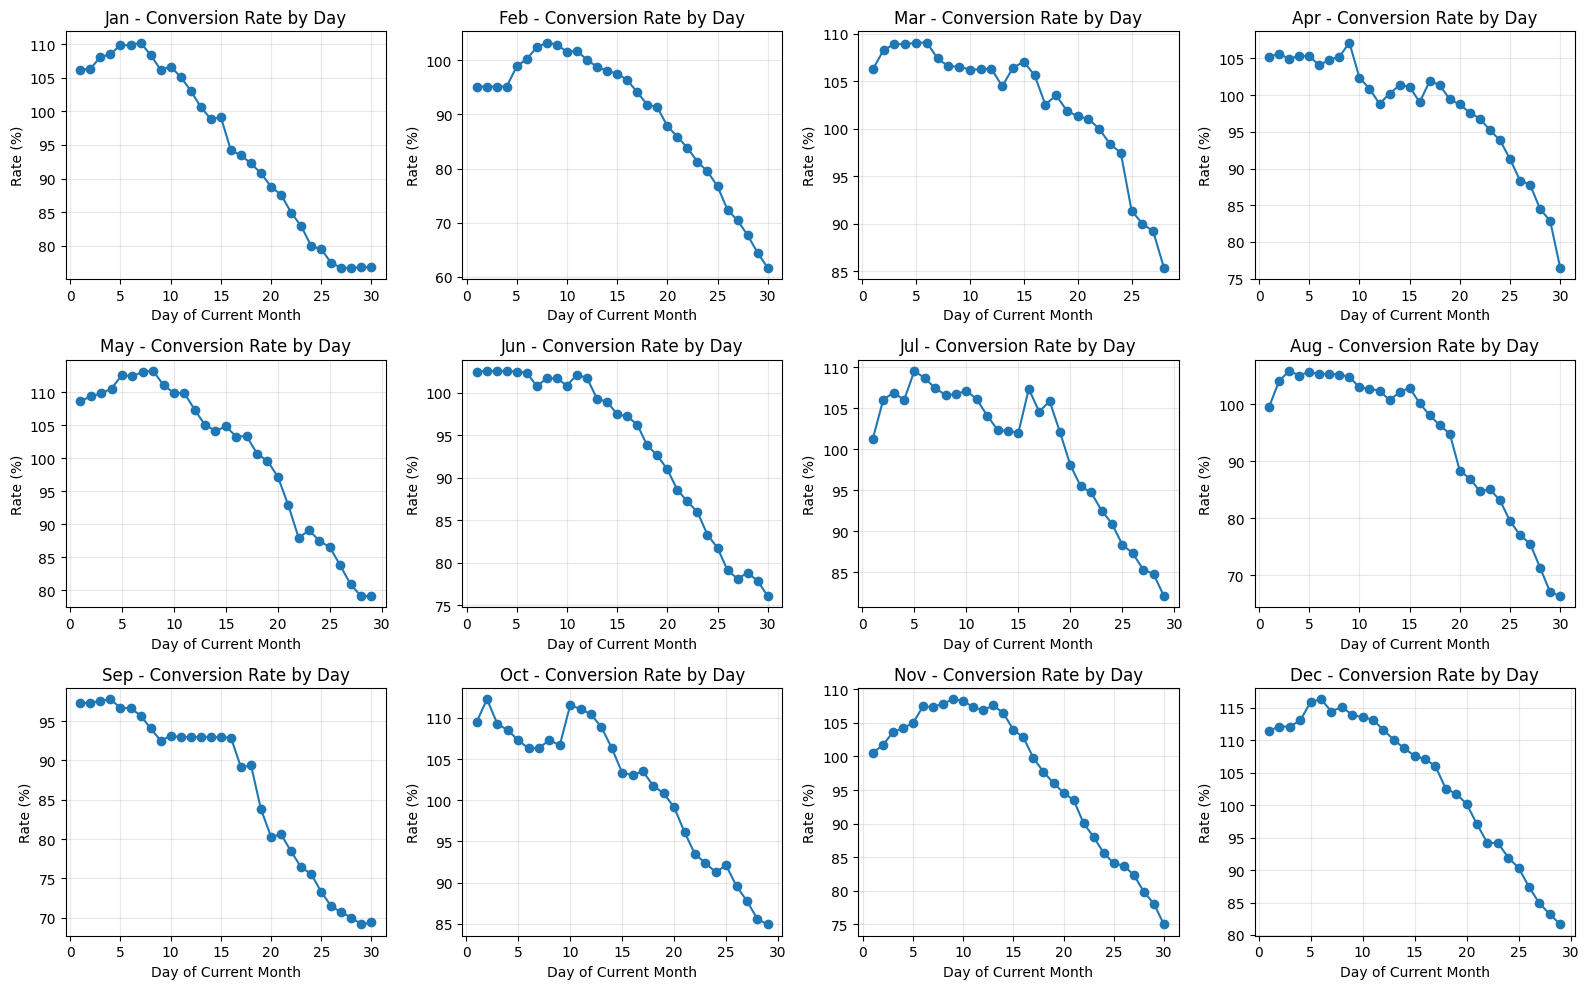

In [8]:
# 月内の日による転換率の変化を可視化
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.flatten()

for m in range(1, 13):
    month_data = train_data[train_data['target_month'] == m]
    if len(month_data) > 0:
        daily_avg = month_data.groupby('day')['Conversion_Rate'].mean()
        axes[m-1].plot(daily_avg.index, daily_avg.values, marker='o')
        axes[m-1].set_title(f'{month_names[m]} - Conversion Rate by Day')
        axes[m-1].set_xlabel('Day of Current Month')
        axes[m-1].set_ylabel('Rate (%)')
        axes[m-1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. モデル構築

In [9]:
class NextMonthMPPredictor:
    def __init__(self):
        self.model = None
        self.monthly_rates = {}
        self.overall_avg_rate = None

    def train(self, data):
        # 予測対象月別の平均転換率を計算
        for m in range(1, 13):
            sub = data[data['target_month'] == m]
            if len(sub) > 0:
                self.monthly_rates[m] = sub['Conversion_Rate'].mean()
        self.overall_avg_rate = data['Conversion_Rate'].mean()

        # Random Forestモデルの訓練
        X = data[['Next_B', 'Next_C', 'Next_D', 'target_month', 'day']]
        y = data['Additional']

        self.model = RandomForestRegressor(
            n_estimators=100,
            max_depth=7,
            random_state=42
        )
        self.model.fit(X, y)

        # モデル評価
        pred_additional = self.model.predict(X)
        pred = data['Next_Month_Start_MP'] + pred_additional

        return {
            'mae': mean_absolute_error(data['Next_Month_End_MP'], pred),
            'r2': r2_score(data['Next_Month_End_MP'], pred)
        }

    def predict(self, next_kakutei, next_a, next_b, next_c, next_d, current_month, current_day):
        """日次の次月データから翌月末のMPを予測"""
        # 翌月のスタートMP
        next_month_start = next_kakutei + next_a
        next_bcd = next_b + next_c + next_d

        # 予測対象月（翌月）
        target_month = (current_month % 12) + 1

        # Random Forestによる予測
        add_rf = self.model.predict([[next_b, next_c, next_d, target_month, current_day]])[0]

        # 月別転換率による予測
        rate = self.monthly_rates.get(target_month, self.overall_avg_rate) / 100
        add_rate = next_bcd * rate

        # ハイブリッド予測
        additional = add_rf * 0.7 + add_rate * 0.3

        return {
            'current_month': current_month,
            'current_day': current_day,
            'target_month': target_month,
            'next_month_start': next_month_start,
            'additional': additional,
            'forecast': next_month_start + additional,
            'next_bcd': next_bcd,
            'rate': rate * 100
        }

print('NextMonthMPPredictor defined!')

NextMonthMPPredictor defined!


In [10]:
predictor = NextMonthMPPredictor()
metrics = predictor.train(train_data)

print('Model Trained!')
print(f'MAE: {metrics["mae"]/10000:,.0f} (10K JPY)')
print(f'R2:  {metrics["r2"]:.3f}')

Model Trained!
MAE: 255 (10K JPY)
R2:  0.930


## 6. 予測実行

In [11]:
def show_prediction(p):
    mn = ['','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    print('='*70)
    print(f'📅 Prediction Date: {mn[p["current_month"]]} {p["current_day"]}')
    print(f'🎯 Target Month: {mn[p["target_month"]]}')
    print('='*70)
    print(f'\n💰 {mn[p["target_month"]]} Start MP (at {mn[p["current_month"]]} end):')
    print(f'   Next Kakutei + Next A = {p["next_month_start"]/10000:>10,.0f} (10K JPY)')
    print(f'   ↑ This is the guaranteed MP for {mn[p["target_month"]]} start')
    print(f'\n📈 Additional MP (predicted growth during {mn[p["target_month"]]}):')
    print(f'   From B, C, D conversion = {p["additional"]/10000:>10,.0f} (10K JPY)')
    print(f'   Conversion Rate: {p["rate"]:.1f}%')
    print(f'\n🎯 {mn[p["target_month"]]} END FORECAST:')
    print(f'   Start MP + Additional = {p["forecast"]/10000:>10,.0f} (10K JPY)')
    print('='*70)

In [12]:
# 最新データで予測
latest = df[~df['is_month_end'] & df['Next_Month_End_MP'].notna()].iloc[-1]
print(f'Latest: {latest["date"].strftime("%Y-%m-%d")}')
print(f'Current Month: {latest["year_month"]}')
print(f'Predicting for: {latest["next_year_month"]}')
print()

p = predictor.predict(
    latest['Next_Kakutei'], latest['Next_A'],
    latest['Next_B'], latest['Next_C'], latest['Next_D'],
    current_month=int(latest['month']),
    current_day=int(latest['day'])
)
show_prediction(p)

# 実際の翌月末MPと比較
if pd.notna(latest['Next_Month_End_MP']):
    actual = latest['Next_Month_End_MP']
    print(f'\nActual Next Month-End MP: {actual/10000:>10,.0f} (10K)')
    print(f'Prediction Error: {abs(p["forecast"] - actual)/10000:>10,.0f} (10K)')

Latest: 2026-01-30
Current Month: 2026-01
Predicting for: 2026-02

📅 Prediction Date: Jan 30
🎯 Target Month: Feb

💰 Feb Start MP (at Jan end):
   Next Kakutei + Next A =      5,298 (10K JPY)
   ↑ This is the guaranteed MP for Feb start

📈 Additional MP (predicted growth during Feb):
   From B, C, D conversion =      2,268 (10K JPY)
   Conversion Rate: 89.7%

🎯 Feb END FORECAST:
   Start MP + Additional =      7,567 (10K JPY)

Actual Next Month-End MP:      6,333 (10K)
Prediction Error:      1,234 (10K)


In [16]:
# カスタム予測例
# 例: 2月9日時点の次月データから5月末を予測
p = predictor.predict(
    next_kakutei=1566619,
    next_a=42835926,
    next_b=22806934,
    next_c=12206329,
    next_d=30976333,
    current_month=2,  # 2月
    current_day=9    # 9日
)
show_prediction(p)

📅 Prediction Date: Feb 9
🎯 Target Month: Mar

💰 Mar Start MP (at Feb end):
   Next Kakutei + Next A =      4,440 (10K JPY)
   ↑ This is the guaranteed MP for Mar start

📈 Additional MP (predicted growth during Mar):
   From B, C, D conversion =      6,762 (10K JPY)
   Conversion Rate: 103.2%

🎯 Mar END FORECAST:
   Start MP + Additional =     11,202 (10K JPY)


## 7. 月内での翌月予測の推移

In [14]:
# 最新月のデータで、日ごとに翌月末の予測がどう変化するかシミュレーション
latest_month = df[(df['year_month'] == df['year_month'].max()) & ~df['is_month_end'] & df['Next_Month_End_MP'].notna()].copy()

if len(latest_month) > 0:
    simulation_results = []

    for _, row in latest_month.iterrows():
        p = predictor.predict(
            row['Next_Kakutei'], row['Next_A'],
            row['Next_B'], row['Next_C'], row['Next_D'],
            current_month=int(row['month']),
            current_day=int(row['day'])
        )
        simulation_results.append({
            'date': row['date'],
            'day': row['day'],
            'next_month_start': p['next_month_start'],
            'additional': p['additional'],
            'forecast': p['forecast'],
            'actual': row['Next_Month_End_MP']
        })

    sim_df = pd.DataFrame(simulation_results)

    current_ym = latest_month.iloc[0]['year_month']
    next_ym = latest_month.iloc[0]['next_year_month']

    # グラフ1: 翌月末予測の推移
    plt.figure(figsize=(14, 6))
    plt.plot(sim_df['day'], sim_df['forecast']/10000,
             label='Predicted Next Month-End MP', marker='o', linewidth=2, color='steelblue')
    plt.axhline(y=sim_df['actual'].iloc[0]/10000,
                color='red', linestyle='--', label='Actual Next Month-End MP', linewidth=2)
    plt.fill_between(sim_df['day'],
                     sim_df['next_month_start']/10000,
                     sim_df['forecast']/10000,
                     alpha=0.3, label='Additional (Predicted)', color='lightblue')

    plt.title(f'Daily Prediction Progress: {current_ym} → {next_ym} End')
    plt.xlabel(f'Day of {current_ym}')
    plt.ylabel('MP (10K JPY)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f'\nDaily prediction for {next_ym} End from each day of {current_ym}:')
    display(sim_df[['day', 'next_month_start', 'additional', 'forecast', 'actual']].head(10))
else:
    print('No data available for simulation')
    print(f'Latest month in data: {df["year_month"].max()}')
    print(f'Months with next month end MP: {df[df["Next_Month_End_MP"].notna()]["year_month"].unique()}')

No data available for simulation
Latest month in data: 2026-02
Months with next month end MP: <PeriodArray>
['2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10',
 '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04', '2021-05',
 '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12',
 '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07',
 '2022-08', '2022-09', '2022-10', '2022-11', '2022-12', '2023-01', '2023-02',
 '2023-03', '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09',
 '2023-10', '2023-11', '2023-12', '2024-01', '2024-02', '2024-03', '2024-04',
 '2024-05', '2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11',
 '2024-12', '2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06',
 '2025-07', '2025-08', '2025-09', '2025-10', '2025-11', '2025-12', '2026-01']
Length: 70, dtype: period[M]


## 8. 翌月スタートMPの推移分析

In [15]:
# 当月の各日における翌月スタートMP（次月確定+次月A）の推移
# セクション7で作成されたデータを使用
latest_month_for_start = df[(df['year_month'] == df['year_month'].max()) & ~df['is_month_end'] & df['Next_Month_End_MP'].notna()].copy()

if len(latest_month_for_start) > 0:
    # 日ごとの翌月スタートMPを計算
    start_mp_results = []

    for _, row in latest_month_for_start.iterrows():
        start_mp_results.append({
            'date': row['date'],
            'day': row['day'],
            'next_month_start': row['Next_Kakutei'] + row['Next_A']
        })

    start_mp_df = pd.DataFrame(start_mp_results)

    current_ym = latest_month_for_start.iloc[0]['year_month']
    next_ym = latest_month_for_start.iloc[0]['next_year_month']

    # グラフ2: 翌月スタートMPの推移
    plt.figure(figsize=(14, 6))
    plt.plot(start_mp_df['day'], start_mp_df['next_month_start']/10000,
             marker='o', linewidth=2, color='green', label=f'{next_ym} Start MP (Kakutei + A)')

    # 最終値を強調
    final_start_mp = start_mp_df['next_month_start'].iloc[-1]
    plt.axhline(y=final_start_mp/10000,
                color='darkgreen', linestyle='--', alpha=0.5,
                label=f'{current_ym} End → {next_ym} Start MP')

    plt.title(f'Next Month Start MP Progress by Day: {current_ym} → {next_ym} Start')
    plt.xlabel(f'Day of {current_ym}')
    plt.ylabel('Next Month Start MP (10K JPY)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f'\n{next_ym} Start MP Statistics:')
    print('='*60)
    print(f'Final ({current_ym} end):  {start_mp_df["next_month_start"].iloc[-1]/10000:>10,.0f} (10K JPY)')
    print(f'Average:                    {start_mp_df["next_month_start"].mean()/10000:>10,.0f} (10K JPY)')
    print(f'Maximum:                    {start_mp_df["next_month_start"].max()/10000:>10,.0f} (10K JPY)')
    print(f'Minimum:                    {start_mp_df["next_month_start"].min()/10000:>10,.0f} (10K JPY)')
    print('='*60)
    print(f'\n💡 Interpretation:')
    print(f'   - By {current_ym} end, {next_ym} will start with {final_start_mp/10000:,.0f} (10K JPY)')
    print(f'   - This is the guaranteed MP (Next Kakutei + Next A) for {next_ym}')
else:
    print('No data available for next month start MP analysis')
    print(f'Latest month in data: {df["year_month"].max()}')
    print(f'Months with next month end MP: {df[df["Next_Month_End_MP"].notna()]["year_month"].unique()}')

No data available for next month start MP analysis
Latest month in data: 2026-02
Months with next month end MP: <PeriodArray>
['2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10',
 '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04', '2021-05',
 '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12',
 '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07',
 '2022-08', '2022-09', '2022-10', '2022-11', '2022-12', '2023-01', '2023-02',
 '2023-03', '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09',
 '2023-10', '2023-11', '2023-12', '2024-01', '2024-02', '2024-03', '2024-04',
 '2024-05', '2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11',
 '2024-12', '2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06',
 '2025-07', '2025-08', '2025-09', '2025-10', '2025-11', '2025-12', '2026-01']
Length: 70, dtype: period[M]
